In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariCNNModel import AtariModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
environment_name  = "SpaceInvadersNoFrameskip-v4"

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [3]:
#play a quick game to test out gym_utils

if False:

    atari_env = AtariEnv(environment_name)
    model = AtariModel(action_count)
    model = model.cuda()
    action = atari_env.env.action_space.sample()

    for i in range(4000):
        atari_frame = atari_env.step(action)
        if atari_frame is None:
            break
        processed_frames = atari_frame.get_next_processed_frames()
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        processed_frames = np.reshape(processed_frames, (1,)+processed_frames.shape)
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        img_tensor = torch.from_numpy(processed_frames).float().cuda()

        output = model(img_tensor)

        action_array = output.detach().cpu().numpy()[0]
        print("model_actions: {}".format(action_array))
        action = np.argmax(action_array)

    atari_env.close()
    
    print("len(atari_env.frame_buffer): {}".format(len(atari_env.frame_buffer)))
    atariFrame = atari_env.frame_buffer[17]
    processed_frames = atariFrame.get_processed_frames()
    print("processed_frames.shape: {}".format(processed_frames.shape))
    print("sample_frame.frame_index: {}".format(atariFrame.frame_index))
    print("sample_frame.reward_list: {}".format(atariFrame.reward_list))
    atariFrame.show_processed_frame()

In [4]:
#play a game. feed each frame into the model and see what we get
def play_game(atari_env, model, epsilon, max_frames=5000):
    model.eval()
    current_action = 0
    done = False
    frame_counter = 0
    
    while not done:
        atari_frame = atari_env.step(current_action)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            current_action = np.argmax(action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def get_train_batch(atari_env, batch_size):
    rand_arr = np.arange(len(atari_env.frame_buffer))
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        atari_frame = atari_env.frame_buffer[frame_number]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [6]:
atari_model_local = AtariModel(action_count).cuda()
atari_model_target = AtariModel(action_count).cuda()


atari_optimizer = optim.Adam(atari_model_local.parameters(), lr=0.0000005)
atari_env_train = AtariEnv(environment_name)



In [ ]:
epochs = 500
gamma = .99
TAU = 1e-3  
epsilon_min = 0.1
epsilon_max = 1.0
epsilon_decay_frames = 2000000
trainings_per_epoch = 4
atari_optimizer.lr= .0000005

for epoch in range(epochs):
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    play_game(atari_env_train, atari_model_local, epsilon)  #TODO - decreasing epsilon

    batch_size = 128
    
    for training_iter in range(trainings_per_epoch):
        frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        atari_optimizer.zero_grad()
        # target_q_values_next = self.qnetwork_target(next_states)
        img_tensor = torch.from_numpy(next_frame_batch).float().cuda()
        target_q_values_next = atari_model_target(img_tensor)
        # print("target_q_values_next:")
        # print(target_q_values_next[:10])
        target_q_values_next_max, indices = torch.max(target_q_values_next, dim=1, keepdim=True)
        # print("target_q_values_next_max: {}".format(target_q_values_next_max[:10]))
        # print("indices: {}".format(indices[:10]))

        # target_q_values_next_max = target_q_values_next_max * (1 - dones)  #remove dones

        # local_q_values = self.qnetwork_local(states)
        img_tensor_next = torch.from_numpy(frame_batch).float().cuda()
        local_q_values = atari_model_local(img_tensor_next)

        # print("local_q_values:")
        # print(local_q_values[:10])

        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).long().cuda()
        #print("actions_batch_tensor.shape: {}".format(actions_batch_tensor.shape))
        #print("local_q_values.shape: {}".format(local_q_values.shape))

        local_q_values_performed = local_q_values.gather(1, actions_batch_tensor)
        #print("local_q_values_performed: {}".format(local_q_values_performed))

        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()

        # print("reward_batch_tensor.shape: {}".format(reward_batch_tensor.shape))
        # print("target_q_values_next_max.shape: {}".format(target_q_values_next_max.shape))
        # print("local_q_values_performed.shape: {}".format(local_q_values_performed.shape))

        # print("reward_batch_tensor[:10]: {}".format(reward_batch_tensor[:10]))
        # print("target_q_values_next_max[:10]: {}".format(target_q_values_next_max[:10]))
        # print("local_q_values_performed[:10]: {}".format(local_q_values_performed[:10]))

        loss = torch.mean((reward_batch_tensor + (gamma * target_q_values_next_max) - local_q_values_performed)**2)
        print("epoch: {},  score: {}, loss: {:.3f}, epsilon: {:.3f}, frames ran: {}".format(epoch, atari_env_train.current_score, loss, epsilon, atari_env_train.global_step_counter))

        loss.backward()
        atari_optimizer.step()

    # ------------------- update target network ------------------- #
    soft_update(atari_model_local, atari_model_target, TAU)    

atari_env_train.close()


epoch: 0,  score: 275.0, loss: 12.725, epsilon: 1.000, frames ran: 3404
epoch: 0,  score: 275.0, loss: 15.306, epsilon: 1.000, frames ran: 3404
epoch: 0,  score: 275.0, loss: 3.146, epsilon: 1.000, frames ran: 3404
epoch: 0,  score: 275.0, loss: 3.163, epsilon: 1.000, frames ran: 3404
epoch: 1,  score: 205.0, loss: 0.003, epsilon: 0.998, frames ran: 6328
epoch: 1,  score: 205.0, loss: 4.109, epsilon: 0.998, frames ran: 6328
epoch: 1,  score: 205.0, loss: 0.003, epsilon: 0.998, frames ran: 6328
epoch: 1,  score: 205.0, loss: 7.046, epsilon: 0.998, frames ran: 6328
epoch: 2,  score: 190.0, loss: 8.282, epsilon: 0.997, frames ran: 8800
epoch: 2,  score: 190.0, loss: 3.936, epsilon: 0.997, frames ran: 8800
epoch: 2,  score: 190.0, loss: 3.523, epsilon: 0.997, frames ran: 8800
epoch: 2,  score: 190.0, loss: 7.293, epsilon: 0.997, frames ran: 8800
epoch: 3,  score: 180.0, loss: 3.539, epsilon: 0.996, frames ran: 11008
epoch: 3,  score: 180.0, loss: 0.397, epsilon: 0.996, frames ran: 11008
ep

epoch: 28,  score: 435.0, loss: 0.989, epsilon: 0.973, frames ran: 62972
epoch: 28,  score: 435.0, loss: 2.170, epsilon: 0.973, frames ran: 62972
epoch: 29,  score: 130.0, loss: 0.003, epsilon: 0.972, frames ran: 64564
epoch: 29,  score: 130.0, loss: 2.556, epsilon: 0.972, frames ran: 64564
epoch: 29,  score: 130.0, loss: 14.092, epsilon: 0.972, frames ran: 64564
epoch: 29,  score: 130.0, loss: 18.419, epsilon: 0.972, frames ran: 64564
epoch: 30,  score: 80.0, loss: 13.915, epsilon: 0.971, frames ran: 66348
epoch: 30,  score: 80.0, loss: 1.958, epsilon: 0.971, frames ran: 66348
epoch: 30,  score: 80.0, loss: 1.766, epsilon: 0.971, frames ran: 66348
epoch: 30,  score: 80.0, loss: 8.838, epsilon: 0.971, frames ran: 66348
epoch: 31,  score: 50.0, loss: 5.879, epsilon: 0.970, frames ran: 67652
epoch: 31,  score: 50.0, loss: 3.144, epsilon: 0.970, frames ran: 67652
epoch: 31,  score: 50.0, loss: 7.039, epsilon: 0.970, frames ran: 67652
epoch: 31,  score: 50.0, loss: 5.890, epsilon: 0.970, f

epoch: 56,  score: 5.0, loss: 3.324, epsilon: 0.948, frames ran: 118096
epoch: 56,  score: 5.0, loss: 0.003, epsilon: 0.948, frames ran: 118096
epoch: 57,  score: 75.0, loss: 6.478, epsilon: 0.947, frames ran: 119752
epoch: 57,  score: 75.0, loss: 1.962, epsilon: 0.947, frames ran: 119752
epoch: 57,  score: 75.0, loss: 1.578, epsilon: 0.947, frames ran: 119752
epoch: 57,  score: 75.0, loss: 7.241, epsilon: 0.947, frames ran: 119752
epoch: 58,  score: 55.0, loss: 3.536, epsilon: 0.946, frames ran: 120924
epoch: 58,  score: 55.0, loss: 317.162, epsilon: 0.946, frames ran: 120924
epoch: 58,  score: 55.0, loss: 12.143, epsilon: 0.946, frames ran: 120924
epoch: 58,  score: 55.0, loss: 5.704, epsilon: 0.946, frames ran: 120924
epoch: 59,  score: 285.0, loss: 0.199, epsilon: 0.946, frames ran: 123644
epoch: 59,  score: 285.0, loss: 12.124, epsilon: 0.946, frames ran: 123644
epoch: 59,  score: 285.0, loss: 7.809, epsilon: 0.946, frames ran: 123644
epoch: 59,  score: 285.0, loss: 0.200, epsilon

epoch: 84,  score: 30.0, loss: 3.156, epsilon: 0.920, frames ran: 179688
epoch: 84,  score: 30.0, loss: 0.002, epsilon: 0.920, frames ran: 179688
epoch: 85,  score: 435.0, loss: 2.736, epsilon: 0.919, frames ran: 182596
epoch: 85,  score: 435.0, loss: 0.788, epsilon: 0.919, frames ran: 182596
epoch: 85,  score: 435.0, loss: 0.002, epsilon: 0.919, frames ran: 182596
epoch: 85,  score: 435.0, loss: 4.875, epsilon: 0.919, frames ran: 182596
epoch: 86,  score: 150.0, loss: 4.099, epsilon: 0.918, frames ran: 184720
epoch: 86,  score: 150.0, loss: 7.279, epsilon: 0.918, frames ran: 184720
epoch: 86,  score: 150.0, loss: 8.795, epsilon: 0.918, frames ran: 184720
epoch: 86,  score: 150.0, loss: 0.002, epsilon: 0.918, frames ran: 184720
epoch: 87,  score: 75.0, loss: 0.002, epsilon: 0.917, frames ran: 186380
epoch: 87,  score: 75.0, loss: 0.389, epsilon: 0.917, frames ran: 186380
epoch: 87,  score: 75.0, loss: 5.100, epsilon: 0.917, frames ran: 186380
epoch: 87,  score: 75.0, loss: 0.002, epsil

epoch: 112,  score: 185.0, loss: 1.766, epsilon: 0.894, frames ran: 238204
epoch: 112,  score: 185.0, loss: 1.574, epsilon: 0.894, frames ran: 238204
epoch: 112,  score: 185.0, loss: 0.796, epsilon: 0.894, frames ran: 238204
epoch: 113,  score: 375.0, loss: 5.657, epsilon: 0.893, frames ran: 240976
epoch: 113,  score: 375.0, loss: 2.565, epsilon: 0.893, frames ran: 240976
epoch: 113,  score: 375.0, loss: 5.679, epsilon: 0.893, frames ran: 240976
epoch: 113,  score: 375.0, loss: 12.732, epsilon: 0.893, frames ran: 240976
epoch: 114,  score: 85.0, loss: 3.350, epsilon: 0.892, frames ran: 242724
epoch: 114,  score: 85.0, loss: 3.522, epsilon: 0.892, frames ran: 242724
epoch: 114,  score: 85.0, loss: 0.203, epsilon: 0.892, frames ran: 242724
epoch: 114,  score: 85.0, loss: 0.789, epsilon: 0.892, frames ran: 242724
epoch: 115,  score: 65.0, loss: 11.140, epsilon: 0.891, frames ran: 244080
epoch: 115,  score: 65.0, loss: 1.967, epsilon: 0.891, frames ran: 244080
epoch: 115,  score: 65.0, los

epoch: 139,  score: 265.0, loss: 6.639, epsilon: 0.871, frames ran: 288892
epoch: 140,  score: 275.0, loss: 6.455, epsilon: 0.870, frames ran: 291480
epoch: 140,  score: 275.0, loss: 0.199, epsilon: 0.870, frames ran: 291480
epoch: 140,  score: 275.0, loss: 0.397, epsilon: 0.870, frames ran: 291480
epoch: 140,  score: 275.0, loss: 4.117, epsilon: 0.870, frames ran: 291480
epoch: 141,  score: 140.0, loss: 1.170, epsilon: 0.869, frames ran: 294056
epoch: 141,  score: 140.0, loss: 2.560, epsilon: 0.869, frames ran: 294056
epoch: 141,  score: 140.0, loss: 3.912, epsilon: 0.869, frames ran: 294056
epoch: 141,  score: 140.0, loss: 1.966, epsilon: 0.869, frames ran: 294056
epoch: 142,  score: 120.0, loss: 0.788, epsilon: 0.868, frames ran: 295196
epoch: 142,  score: 120.0, loss: 0.596, epsilon: 0.868, frames ran: 295196
epoch: 142,  score: 120.0, loss: 5.287, epsilon: 0.868, frames ran: 295196
epoch: 142,  score: 120.0, loss: 0.001, epsilon: 0.868, frames ran: 295196
epoch: 143,  score: 170.0

epoch: 167,  score: 35.0, loss: 1.164, epsilon: 0.845, frames ran: 344680
epoch: 167,  score: 35.0, loss: 5.679, epsilon: 0.845, frames ran: 344680
epoch: 167,  score: 35.0, loss: 8.834, epsilon: 0.845, frames ran: 344680
epoch: 168,  score: 180.0, loss: 0.985, epsilon: 0.845, frames ran: 346764
epoch: 168,  score: 180.0, loss: 10.531, epsilon: 0.845, frames ran: 346764
epoch: 168,  score: 180.0, loss: 1.360, epsilon: 0.845, frames ran: 346764
epoch: 168,  score: 180.0, loss: 3.720, epsilon: 0.845, frames ran: 346764
epoch: 169,  score: 30.0, loss: 0.787, epsilon: 0.844, frames ran: 347876
epoch: 169,  score: 30.0, loss: 1.767, epsilon: 0.844, frames ran: 347876
epoch: 169,  score: 30.0, loss: 0.002, epsilon: 0.844, frames ran: 347876
epoch: 169,  score: 30.0, loss: 0.967, epsilon: 0.844, frames ran: 347876
epoch: 170,  score: 270.0, loss: 4.110, epsilon: 0.843, frames ran: 350984
epoch: 170,  score: 270.0, loss: 4.896, epsilon: 0.843, frames ran: 350984
epoch: 170,  score: 270.0, loss

epoch: 194,  score: 60.0, loss: 2.556, epsilon: 0.822, frames ran: 397100
epoch: 195,  score: 85.0, loss: 0.002, epsilon: 0.821, frames ran: 398668
epoch: 195,  score: 85.0, loss: 0.002, epsilon: 0.821, frames ran: 398668
epoch: 195,  score: 85.0, loss: 0.783, epsilon: 0.821, frames ran: 398668
epoch: 195,  score: 85.0, loss: 1.774, epsilon: 0.821, frames ran: 398668
epoch: 196,  score: 120.0, loss: 0.002, epsilon: 0.821, frames ran: 400512
epoch: 196,  score: 120.0, loss: 6.649, epsilon: 0.821, frames ran: 400512
epoch: 196,  score: 120.0, loss: 0.978, epsilon: 0.821, frames ran: 400512
epoch: 196,  score: 120.0, loss: 1.374, epsilon: 0.821, frames ran: 400512


In [8]:
#play a game using the model
atari_env_play = AtariEnv(environment_name)
#play_game(atari_env_play, atari_model_local, 0.05, max_frames=2000)
play_game(atari_env_play, atari_model_target, 0.05, max_frames=2000)
#print("score: {}".format(atari_env_play.current_score))
atari_env_play.close()

action: 0.0
reward: 0.0
frame:  862.0


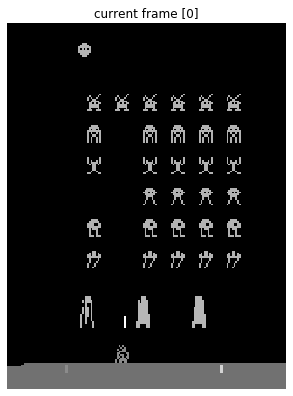

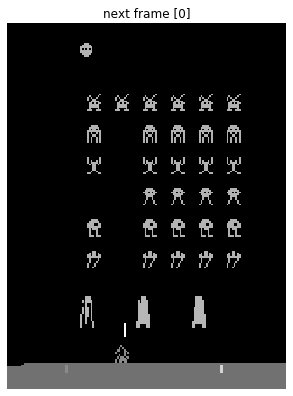

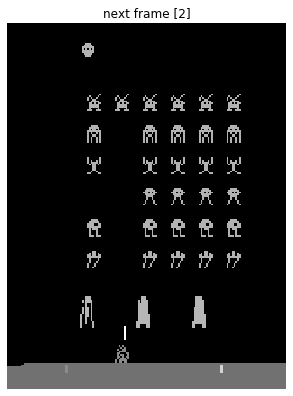

In [95]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()